# Case DS - Mercado Livre
# Challenge 1 - EDA

## 1. Importação dos pacotes e funções

### 1.1 Bibliotecas utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly.express as px
from IPython.display import display
from pandas.plotting import autocorrelation_plot
import warnings
import datetime

### 1.2 Configurações

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
sns.set_palette("gist_ncar")
sns.set_style("whitegrid")

In [3]:
def plot_ratio_horizontal(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        y = p.get_y() + p.get_height() / 2 + 0.12
        x = p.get_x() + p.get_width()
        ax.annotate(percentage, (x, y), size=13)
    plt.show()

In [4]:
# esta função adiciona o valor relativo da categoria num gráfico de barras vertical
def plot_ratio(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.10
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=13)
    plt.show()

In [5]:
def correlated_columns(df, threshold):
    return (
        df.corr()
        .pipe(
            lambda df1: pd.DataFrame(
                np.tril(df1, k=-1),
                columns=df.columns,
                index=df.columns,
            )
        )
        .stack()
        .rename("kendall")
        .pipe(
            lambda s: s[
                s.abs() > threshold
            ].reset_index()
        )
        .query("level_0 not in level_1")
    )

In [6]:
def fill_categoric_field_with_value(serie):
    names = serie.unique()
    values = list(range(1, names.size + 1))
    
    #a tabela de valores continha um float(nan) mapeado para um valor inteiro. Solução foi mudar na tabela de valores colocando o None
    nan_index = np.where(pd.isna(names))
    if len(nan_index) > 0 and len(nan_index[0]) > 0:
        nan_index = nan_index[0][0]
        values[nan_index] = None
    #else:
        #print("Não encontrou nan em " + str(names))
        
    return serie.replace(names,values)

# 2. Obtenção dos dados 

## 2.1 Importação dos dados

In [7]:
# Read sqlite query results into a pandas DataFrame
df = pd.read_csv('ofertas_relampago.csv')

In [8]:
df.head() # exibindo as primeiras linhas

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES


In [9]:
df.tail() # exibindo as últimas linhas

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
48741,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,15,9,16.28,6.0,NaN,none,HOME&DECOR,HOME & INDUSTRY,MLM-CHRISTMAS_LIGHTS
48742,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-DECORATIVE_PAINTINGS
48743,2021-06-19,2021-06-19 07:00:00+00:00,2021-06-19 13:00:03+00:00,lightning_deal,5,3,16.62,2.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS
48744,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:00+00:00,lightning_deal,5,1,38.79,4.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS
48745,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:00+00:00,lightning_deal,15,15,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-BED_SHEETS


In [10]:
print('A base possui', df.shape[0], 'linhas e', df.shape[1], 'variáveis (atributos)')

A base possui 48746 linhas e 13 variáveis (atributos)


# 3. Análise da qualidade dos dados

In [11]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
INVOLVED_STOCK,48746.00,35.01,206.76,1.00,5.00,10.00,15.00,9000.00
REMAINING_STOCK_AFTER_END,48746.00,30.57,195.81,-192.00,4.00,8.00,15.00,8635.00
SOLD_AMOUNT,24579.00,51.21,175.25,0.28,5.73,12.42,30.93,4836.57
SOLD_QUANTITY,24579.00,10.85,45.48,1.00,1.00,3.00,6.00,1646.00


In [12]:
df_zeros = (df == 0).mean()
df_zeros = df_zeros[df_zeros > 0] * 100
print("Colunas com valores zero (qtd relativa): \n\n{}\n".format(df_zeros.sort_values(ascending = False)))

Colunas com valores zero (qtd relativa): 

REMAINING_STOCK_AFTER_END    6.131785
dtype: float64



## 3.1 Tipos dos dados

In [13]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48746 entries, 0 to 48745
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OFFER_START_DATE           48746 non-null  object 
 1   OFFER_START_DTTM           48746 non-null  object 
 2   OFFER_FINISH_DTTM          48746 non-null  object 
 3   OFFER_TYPE                 48746 non-null  object 
 4   INVOLVED_STOCK             48746 non-null  int64  
 5   REMAINING_STOCK_AFTER_END  48746 non-null  int64  
 6   SOLD_AMOUNT                24579 non-null  float64
 7   SOLD_QUANTITY              24579 non-null  float64
 8   ORIGIN                     11316 non-null  object 
 9   SHIPPING_PAYMENT_TYPE      48746 non-null  object 
 10  DOM_DOMAIN_AGG1            48746 non-null  object 
 11  VERTICAL                   48746 non-null  object 
 12  DOMAIN_ID                  48746 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usag

## 3.2 Valores ausentes

In [14]:
print(df.isnull().sum())

df_null = df.isnull().mean(axis = 0)
df_null = df_null[df_null > 0] * 100
print("\n Colunas com valores ausentes (qtd relativa): \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

OFFER_START_DATE                 0
OFFER_START_DTTM                 0
OFFER_FINISH_DTTM                0
OFFER_TYPE                       0
INVOLVED_STOCK                   0
REMAINING_STOCK_AFTER_END        0
SOLD_AMOUNT                  24167
SOLD_QUANTITY                24167
ORIGIN                       37430
SHIPPING_PAYMENT_TYPE            0
DOM_DOMAIN_AGG1                  0
VERTICAL                         0
DOMAIN_ID                        0
dtype: int64

 Colunas com valores ausentes (qtd relativa): 

ORIGIN           76.785788
SOLD_AMOUNT      49.577401
SOLD_QUANTITY    49.577401
dtype: float64



### 3.2.1 Tratamento dos valores nulos

In [16]:
# Sold será zero quando stock final for igual ao stock inicial
df.loc[df['INVOLVED_STOCK'] == df['REMAINING_STOCK_AFTER_END'], ('SOLD_AMOUNT', 'SOLD_QUANTITY')] = (0, 0)
# Sold nulo porém diferença no estoque, consideramos erro nas informações. Por isso retiramos da base
df.drop(index=df[(df['INVOLVED_STOCK'] > df['REMAINING_STOCK_AFTER_END']) & (df['SOLD_AMOUNT'].isnull()) & (df['SOLD_QUANTITY'].isnull())].index, inplace=True)

In [17]:
print(df.isnull().sum())

df_null = df.isnull().mean(axis = 0)
df_null = df_null[df_null > 0] * 100
print("\n Colunas com valores ausentes (qtd relativa): \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

OFFER_START_DATE                 0
OFFER_START_DTTM                 0
OFFER_FINISH_DTTM                0
OFFER_TYPE                       0
INVOLVED_STOCK                   0
REMAINING_STOCK_AFTER_END        0
SOLD_AMOUNT                      0
SOLD_QUANTITY                    0
ORIGIN                       37077
SHIPPING_PAYMENT_TYPE            0
DOM_DOMAIN_AGG1                  0
VERTICAL                         0
DOMAIN_ID                        0
dtype: int64

 Colunas com valores ausentes (qtd relativa): 

ORIGIN    76.990324
dtype: float64



## 3.3 Valores únicos por variável

In [18]:
pd.options.display.max_rows = 118
print('Valores únicos em cada variável: \n')
df.nunique(dropna=False).sort_values()

Valores únicos em cada variável: 



OFFER_TYPE                      1
ORIGIN                          2
SHIPPING_PAYMENT_TYPE           2
VERTICAL                        9
DOM_DOMAIN_AGG1                36
OFFER_START_DATE               61
SOLD_QUANTITY                 374
INVOLVED_STOCK                505
OFFER_START_DTTM              783
REMAINING_STOCK_AFTER_END     801
DOMAIN_ID                    1266
OFFER_FINISH_DTTM            7511
SOLD_AMOUNT                  7599
dtype: int64

In [19]:
df['OFFER_TYPE'].unique()

array(['lightning_deal'], dtype=object)

In [20]:
df['ORIGIN'].unique()

array(['A', nan], dtype=object)

In [21]:
df['SHIPPING_PAYMENT_TYPE'].unique()

array(['none', 'free_shipping'], dtype=object)

In [22]:
df['VERTICAL'].unique()

array(['CPG', 'OTHERS', 'CE', 'APP & SPORTS', 'T & B', 'BEAUTY & HEALTH',
       'HOME & INDUSTRY', 'ENTERTAINMENT', 'ACC'], dtype=object)

In [23]:
df['DOM_DOMAIN_AGG1'].unique()

array(['PETS FOOD', 'PET PRODUCTS', 'COMPUTERS', 'ELECTRONICS', 'APPAREL',
       'PARTY', 'TOYS AND GAMES', 'PERSONAL CARE', 'INDUSTRY',
       'TOOLS AND CONSTRUCTION', 'HOME&DECOR', 'SPORTS',
       'BOOKS, MULTIMEDIA & OTHER E!', 'AUTOPARTS', 'DRINKS', 'FOOTWEAR',
       'WHEELS & TIRES', 'BEAUTY EQUIPMENT', 'MOBILE',
       'APPAREL ACCESORIES', 'FOODS', 'PHARMACEUTICS', 'STATIONARY',
       'BABY', 'PERSONAL HYGIENE', 'OTHER', 'VEHICULAR MULTIMEDIA',
       'SUPLEMENTS', 'SECURITY', 'MOTOPARTS', 'CLEANING', 'ACC TOOLS',
       'MUSICAL INSTRUMENTS', 'ANTIQUES & HOBBIES', 'BATTERIES', 'AGRO'],
      dtype=object)

## 3.4 Criação de novas variáveis

### 3.4.1 Variável de duração da campanha

In [24]:
df['OFFER_FINISH_DTTM'] = pd.to_datetime(df['OFFER_FINISH_DTTM'])
df['OFFER_START_DTTM'] = pd.to_datetime(df['OFFER_START_DTTM'])
df["OFFER_DURATION_HOUR"] = round((df["OFFER_FINISH_DTTM"] - df["OFFER_START_DTTM"]).dt.total_seconds()/3600,0)
df["OFFER_DURATION_MIN"] = round((df["OFFER_FINISH_DTTM"] - df["OFFER_START_DTTM"]).dt.total_seconds()/60,0)

### 3.4.2 Variáveis de controle do estoque

In [25]:
df.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,OFFER_DURATION_HOUR,OFFER_DURATION_MIN
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS,7.0,423.0
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0.0,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,6.0,360.0
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS,6.0,360.0
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,7.0,396.0
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,3.0,168.0


In [26]:
df['FINAL_STOCK'] = df['INVOLVED_STOCK'] - df['SOLD_QUANTITY']

In [27]:
df['STOCK_SOLD_PERC'] = round(df['SOLD_QUANTITY'] / df['INVOLVED_STOCK'] * 100, 2)

### 3.4.3 Informações do início da campanha

In [28]:
df['START_MONTH'] = df['OFFER_START_DTTM'].dt.month
df['START_WEEK_DAY'] = df['OFFER_START_DTTM'].dt.day_name()
df['START_DAY'] = df['OFFER_START_DTTM'].dt.day
df['START_HOUR'] = df['OFFER_START_DTTM'].dt.hour
df['START_YEAR'] = df['OFFER_START_DTTM'].dt.year

In [29]:
np.sort(df['START_YEAR'].unique())

array([2021], dtype=int64)

In [30]:
np.sort(df['START_WEEK_DAY'].unique())

array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)

In [31]:
np.sort(df['START_DAY'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [32]:
np.sort(df['START_MONTH'].unique())

array([6, 7], dtype=int64)

In [33]:
np.sort(df['START_HOUR'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [34]:
df['OFFER_DURATION_HOUR'] = df['OFFER_DURATION_HOUR'].apply(lambda x: f"{int(x):02} h" if x<11 else "10+ h")

In [35]:
df.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,OFFER_DURATION_HOUR,OFFER_DURATION_MIN,FINAL_STOCK,STOCK_SOLD_PERC,START_MONTH,START_WEEK_DAY,START_DAY,START_HOUR,START_YEAR
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS,07 h,423.0,-2.0,150.00,6,Tuesday,22,16,2021
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0.0,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,06 h,360.0,5.0,0.00,6,Tuesday,22,13,2021
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS,06 h,360.0,12.0,20.00,6,Tuesday,22,7,2021
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,07 h,396.0,13.0,13.33,6,Tuesday,22,19,2021
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES,03 h,168.0,0.0,100.00,6,Tuesday,22,13,2021


## 3.5 Tratamento de possíveis inconsistências

In [36]:
#Verificando casos onde o stock final é diferente da subtração entre o inicial e o vendido
df['DIFF_STOCK'] = df['INVOLVED_STOCK'] - df['SOLD_QUANTITY']
df['STOCK_DIVERGENCE'] = df['REMAINING_STOCK_AFTER_END'] - df['DIFF_STOCK']
df[df['STOCK_DIVERGENCE'] != 0].shape[0]

2782

2.782 casos com inconsistência entre os dados de estoque.

In [38]:
df = df.drop(df[df['STOCK_DIVERGENCE'] != 0].index)
df.drop(index=df[(df['INVOLVED_STOCK'] == df['REMAINING_STOCK_AFTER_END']) & ((df['SOLD_AMOUNT'] != 0) | (df['SOLD_QUANTITY'] != 0))].index, inplace=True)

# 4. Análise das variáveis

## 4.1 Análise da duração da campanha

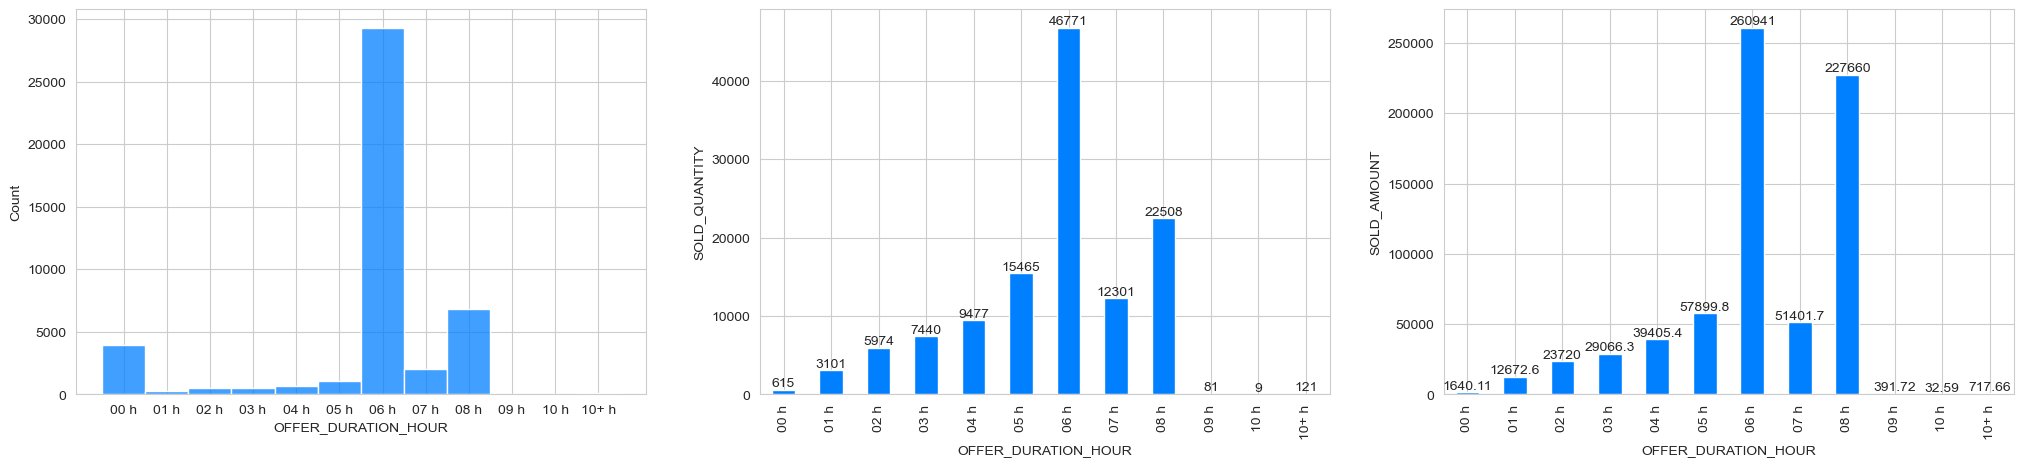

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

sns.histplot(df['OFFER_DURATION_HOUR'].sort_values(), ax=ax1)

df.groupby('OFFER_DURATION_HOUR')['SOLD_QUANTITY'].sum().plot(kind='bar', ax=ax2)
ax2.set_ylabel('SOLD_QUANTITY')
for i in ax2.containers:
    ax2.bar_label(i, label_type='edge', fontsize=10)

df.groupby('OFFER_DURATION_HOUR')['SOLD_AMOUNT'].sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('SOLD_AMOUNT')
for i in ax3.containers:
    ax3.bar_label(i, label_type='edge', fontsize=10)

plt.show()

Podemos ver que as temos mais campanhas durando de 6 a 8 horas. O que podemos comprovar que é a melhor duração de campanha, pois são as que mais vendem tanto em quantidade como em valor.

In [40]:
df[df['OFFER_DURATION_HOUR'] == '00 h'].shape[0]

3931

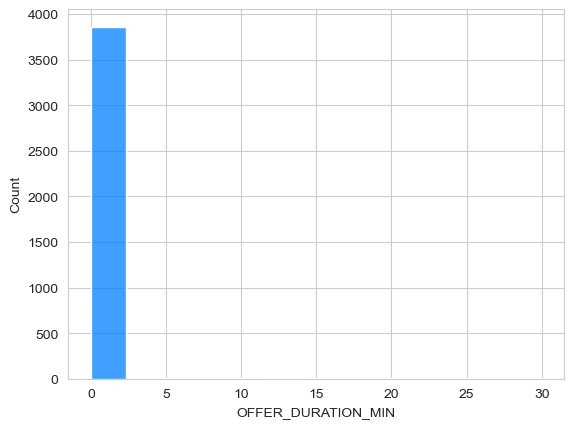

In [41]:
sns.histplot(df[df['OFFER_DURATION_HOUR'] == '00 h']['OFFER_DURATION_MIN'].sort_values())
plt.show()

In [42]:
df[df['OFFER_DURATION_MIN'] == 0].shape[0]

3693

In [43]:
df.drop(df[df['OFFER_DURATION_MIN'] == 0].index, inplace=True)

Campanhas que tem duração de 0 minutos não deveria haver tempo para compra. Analisar se é um erro da data fim da campanha, ou se ela realmente acabou rápido.

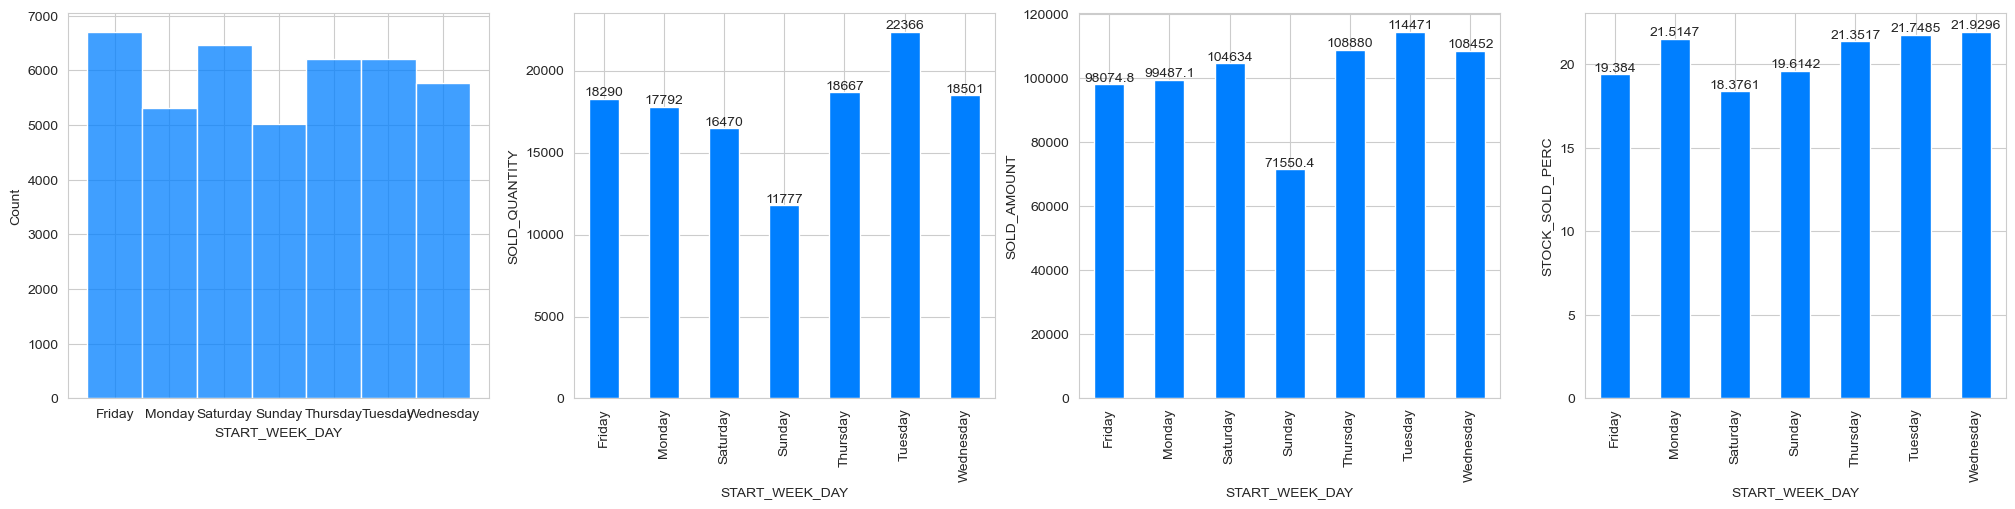

In [44]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5))

sns.histplot(df['START_WEEK_DAY'].sort_values(), ax=ax1)

df.groupby('START_WEEK_DAY')['SOLD_QUANTITY'].sum().plot(kind='bar', ax=ax2)
ax2.set_ylabel('SOLD_QUANTITY')
for i in ax2.containers:
    ax2.bar_label(i, label_type='edge', fontsize=10)

df.groupby('START_WEEK_DAY')['SOLD_AMOUNT'].sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('SOLD_AMOUNT')
for i in ax3.containers:
    ax3.bar_label(i, label_type='edge', fontsize=10)
    
    
df.groupby('START_WEEK_DAY')['STOCK_SOLD_PERC'].mean().plot(kind='bar', ax=ax4)
ax4.set_ylabel('STOCK_SOLD_PERC')
for i in ax4.containers:
    ax4.bar_label(i, label_type='edge', fontsize=10)

plt.show()

Podemos observar que os dias da semana que tem mais venda seriam a segunda, terça, quarta e quinta. Mesmo tendo menos campanhas do que na sexta e no sabádo, as campanhas desses dias (segunda,terça, quarta e quinta) acabam vendendo mais. Poderíamos direcionar as próximas campanhas para esses dias, visando maximizar a venda.

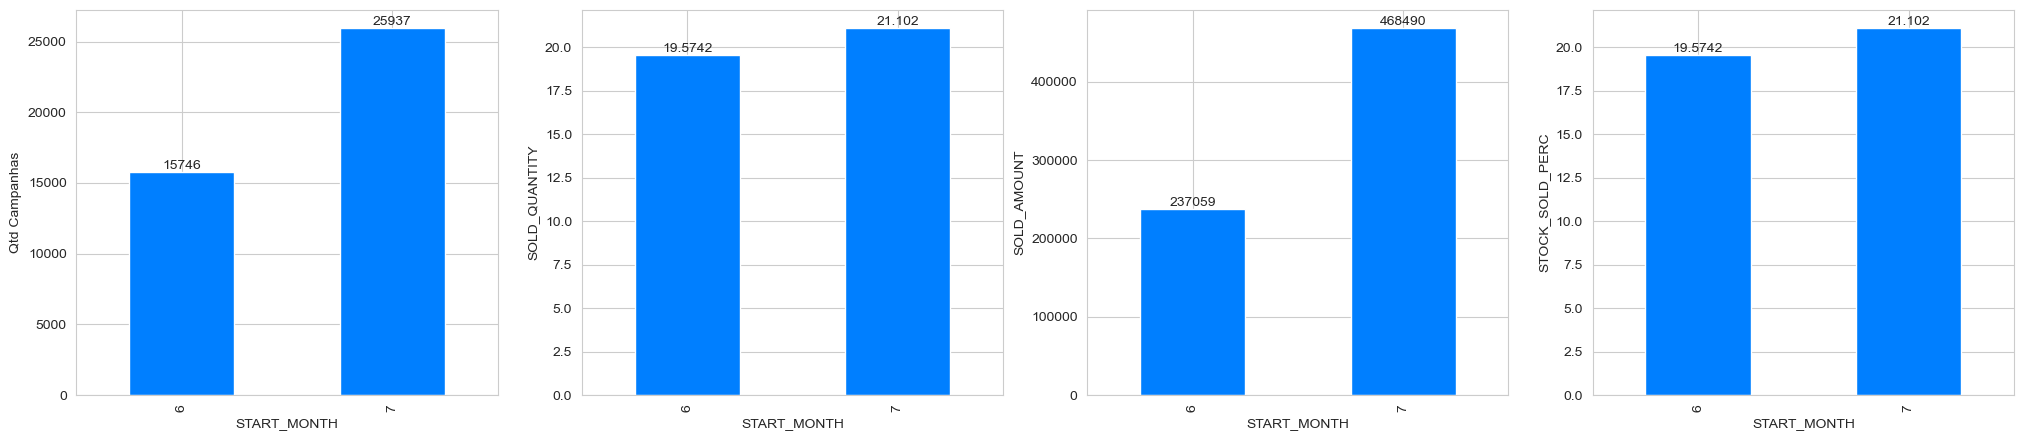

In [45]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5))

df['START_MONTH'].value_counts().sort_index().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Qtd Campanhas')
ax1.set_xlabel('START_MONTH')
for i in ax1.containers:
    ax1.bar_label(i, label_type='edge', fontsize=10)

df.groupby('START_MONTH')['STOCK_SOLD_PERC'].mean().plot(kind='bar', ax=ax2)
ax2.set_ylabel('SOLD_QUANTITY')
for i in ax2.containers:
    ax2.bar_label(i, label_type='edge', fontsize=10)

df.groupby('START_MONTH')['SOLD_AMOUNT'].sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('SOLD_AMOUNT')
for i in ax3.containers:
    ax3.bar_label(i, label_type='edge', fontsize=10)
   
    
df.groupby('START_MONTH')['STOCK_SOLD_PERC'].mean().plot(kind='bar', ax=ax4)
ax4.set_ylabel('STOCK_SOLD_PERC')
for i in ax4.containers:
    ax4.bar_label(i, label_type='edge', fontsize=10)

plt.show()

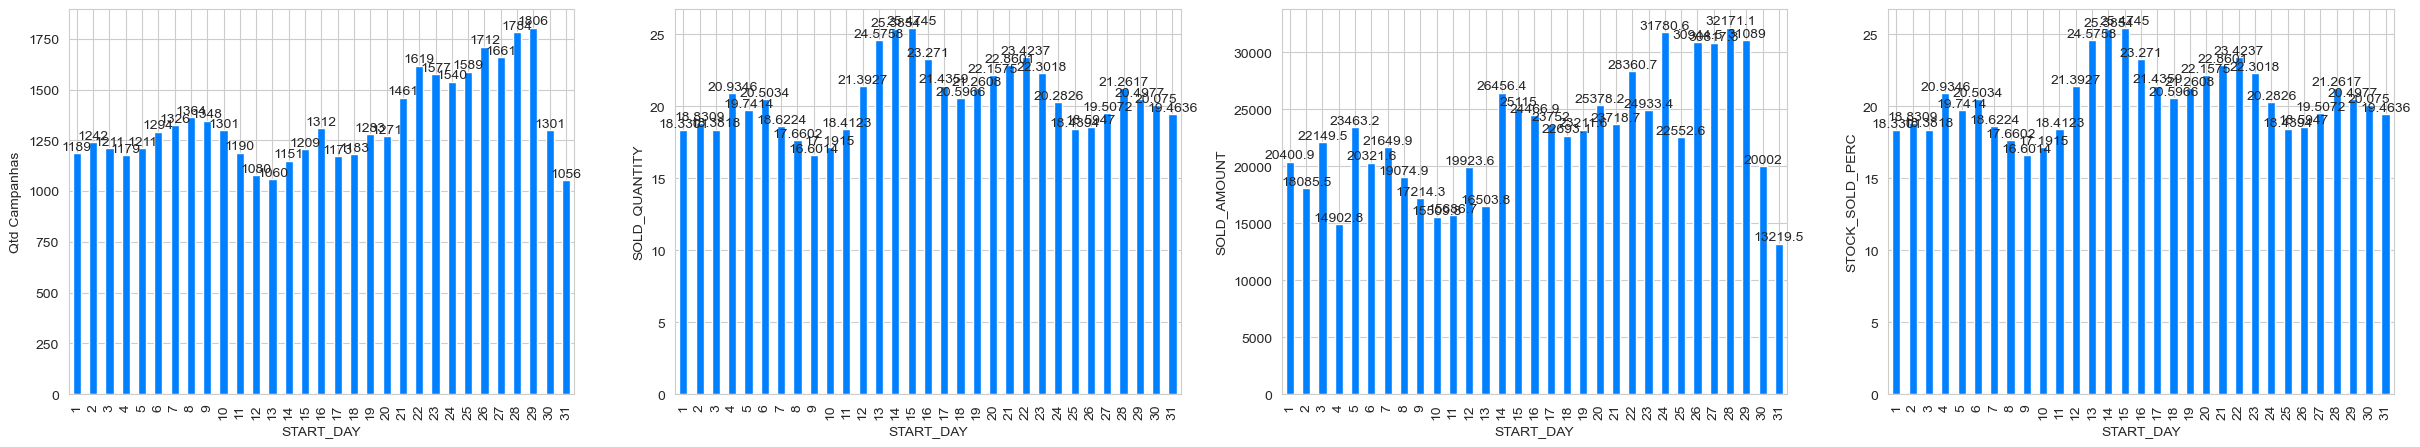

In [46]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

df['START_DAY'].value_counts().sort_index().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Qtd Campanhas')
ax1.set_xlabel('START_DAY')
for i in ax1.containers:
    ax1.bar_label(i, label_type='edge', fontsize=10)

df.groupby('START_DAY')['STOCK_SOLD_PERC'].mean().plot(kind='bar', ax=ax2)
ax2.set_ylabel('SOLD_QUANTITY')
for i in ax2.containers:
    ax2.bar_label(i, label_type='edge', fontsize=10)

df.groupby('START_DAY')['SOLD_AMOUNT'].sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('SOLD_AMOUNT')
for i in ax3.containers:
    ax3.bar_label(i, label_type='edge', fontsize=10)
    
df.groupby('START_DAY')['STOCK_SOLD_PERC'].mean().plot(kind='bar', ax=ax4)
ax4.set_ylabel('STOCK_SOLD_PERC')
for i in ax4.containers:
    ax4.bar_label(i, label_type='edge', fontsize=10)

plt.show()

Podemos observar que temos mais campanhas no final do mês, onde realmente há mais venda. Porém podemos ver que os valores das vendar são relativamente altos para o meio do mês, entre 15 e 25.
Isso poderia ser explicado pois no final do mês as pessoas teriam menor poder de compra, onde no meio do mês não teria esse problema.

## 4.2 Análise da hora de início da campanha

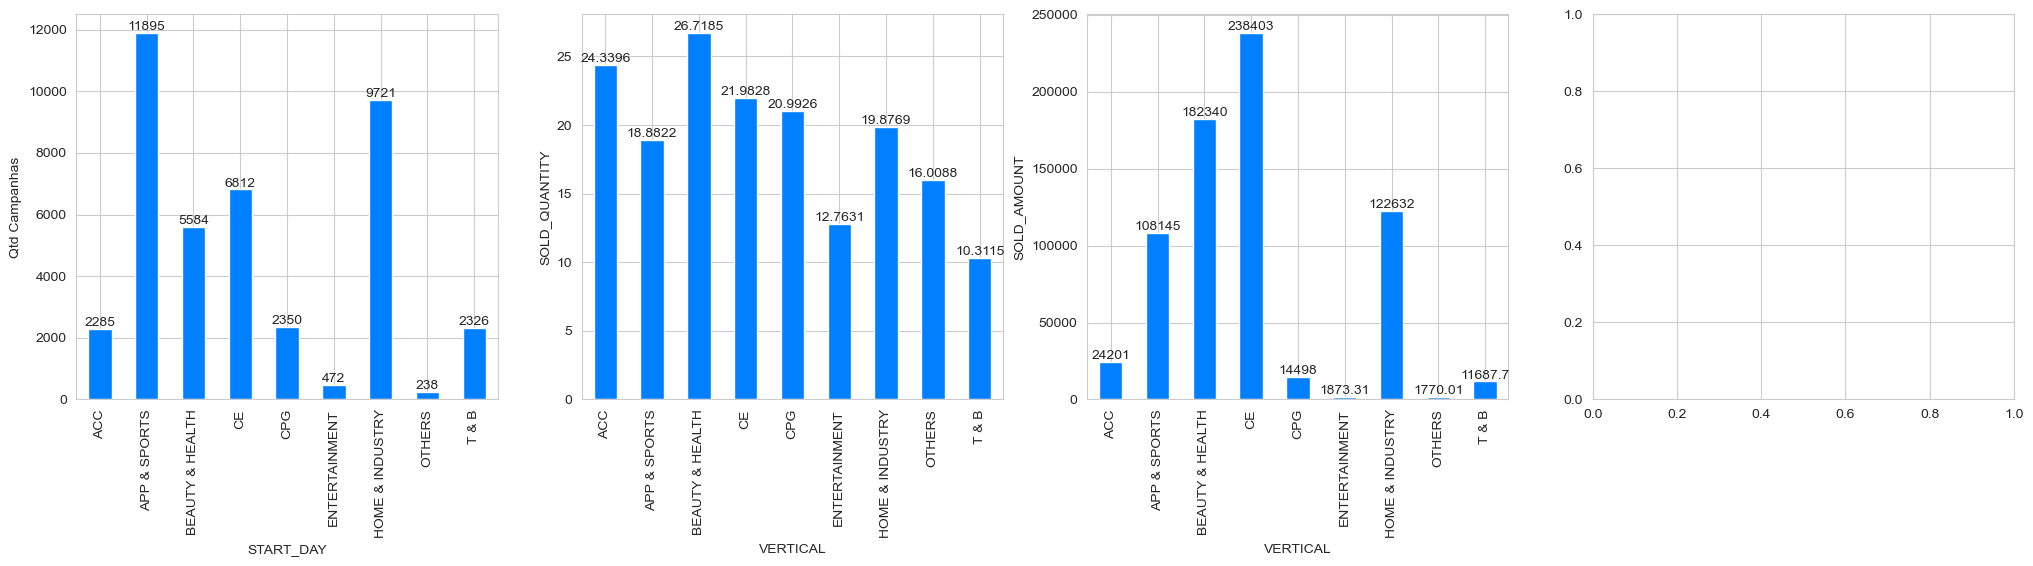

In [47]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5))

df['VERTICAL'].value_counts().sort_index().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Qtd Campanhas')
ax1.set_xlabel('START_DAY')
for i in ax1.containers:
    ax1.bar_label(i, label_type='edge', fontsize=10)

df.groupby('VERTICAL')['STOCK_SOLD_PERC'].mean().plot(kind='bar', ax=ax2)
ax2.set_ylabel('SOLD_QUANTITY')
for i in ax2.containers:
    ax2.bar_label(i, label_type='edge', fontsize=10)

df.groupby('VERTICAL')['SOLD_AMOUNT'].sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('SOLD_AMOUNT')
for i in ax3.containers:
    ax3.bar_label(i, label_type='edge', fontsize=10)

plt.show()

Conseguimos observar que as 'Verticais' que mais vendem são :'BEAUTY & HEALTH' e 'HOME & INDUSTRY', Porém quando analisamos os que vendem mais em relação ao valor chegamos nas 'Verticais' : 'CE' e 'BEAUTY & HEALTH'
Isso se explicaria caso a Vertical CE tenha produtos mais caros, com isso mesmo com menor quantidade de produtos vendidos, temos como a vertical que mais vendeu em relação a valor.

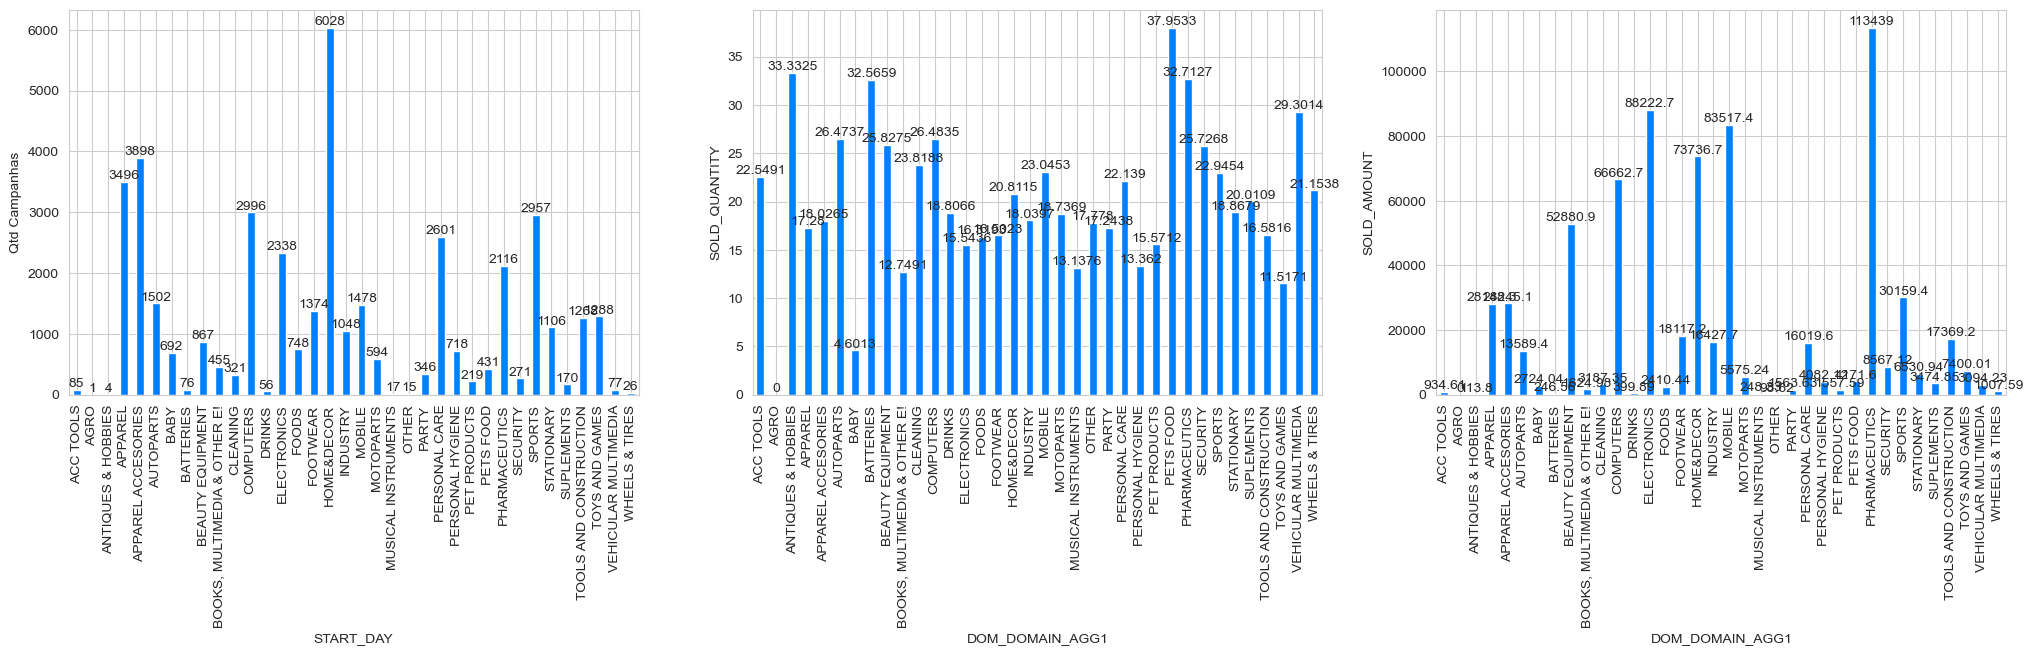

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

df['DOM_DOMAIN_AGG1'].value_counts().sort_index().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Qtd Campanhas')
ax1.set_xlabel('START_DAY')
for i in ax1.containers:
    ax1.bar_label(i, label_type='edge', fontsize=10)

df.groupby('DOM_DOMAIN_AGG1')['STOCK_SOLD_PERC'].mean().plot(kind='bar', ax=ax2)
ax2.set_ylabel('SOLD_QUANTITY')
for i in ax2.containers:
    ax2.bar_label(i, label_type='edge', fontsize=10)

df.groupby('DOM_DOMAIN_AGG1')['SOLD_AMOUNT'].sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('SOLD_AMOUNT')
for i in ax3.containers:
    ax3.bar_label(i, label_type='edge', fontsize=10)

plt.show()

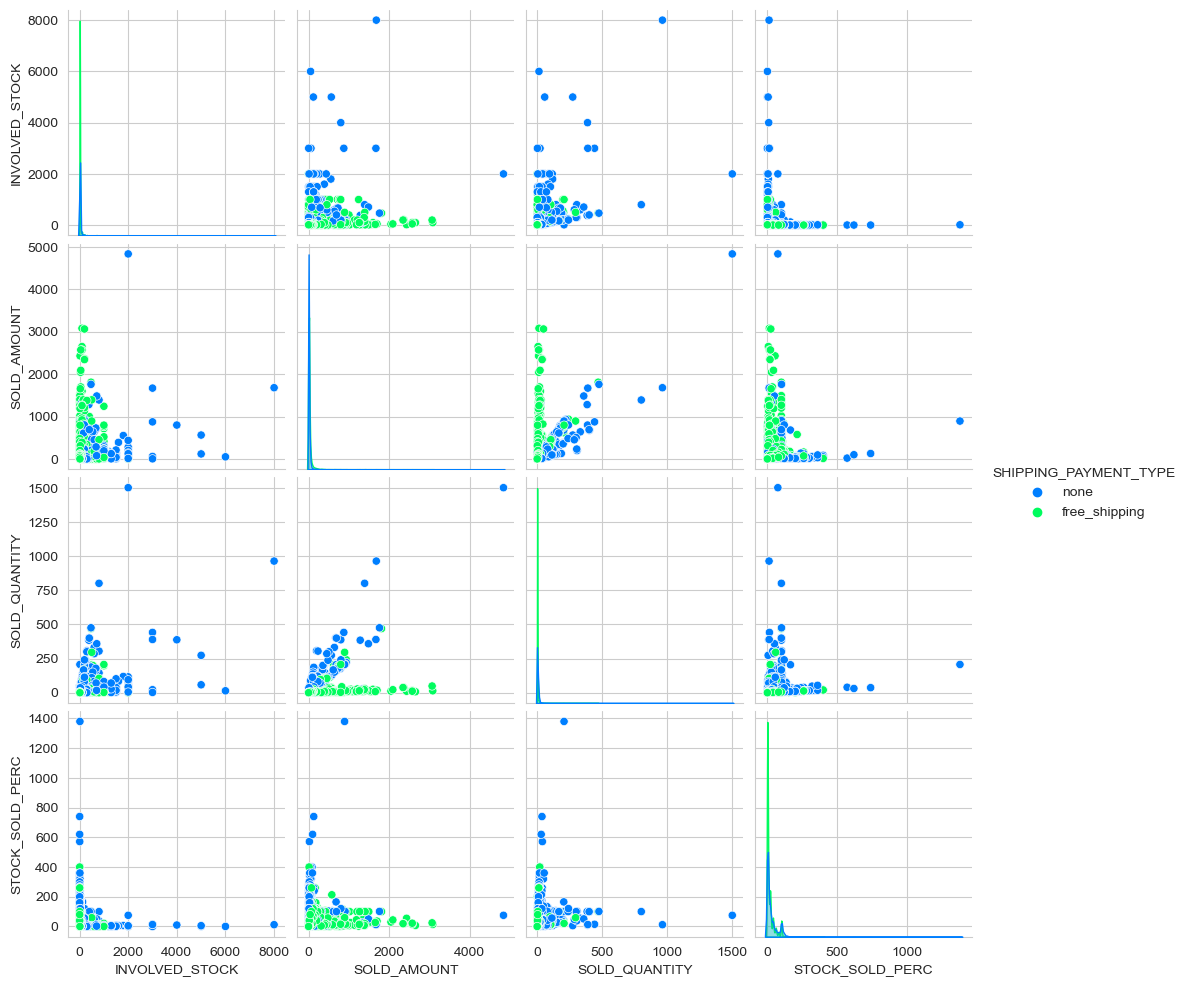

In [50]:
numeric_cols_ship = ['INVOLVED_STOCK','SOLD_AMOUNT', 'SOLD_QUANTITY','STOCK_SOLD_PERC','SHIPPING_PAYMENT_TYPE']
sns.pairplot(df[numeric_cols_ship], hue = 'SHIPPING_PAYMENT_TYPE')
plt.show()

# 6. Análise da correlação das colunas

In [51]:
df['VERTICAL'] = fill_categoric_field_with_value(df['VERTICAL'])
df['DOM_DOMAIN_AGG1'] = fill_categoric_field_with_value(df['DOM_DOMAIN_AGG1'])

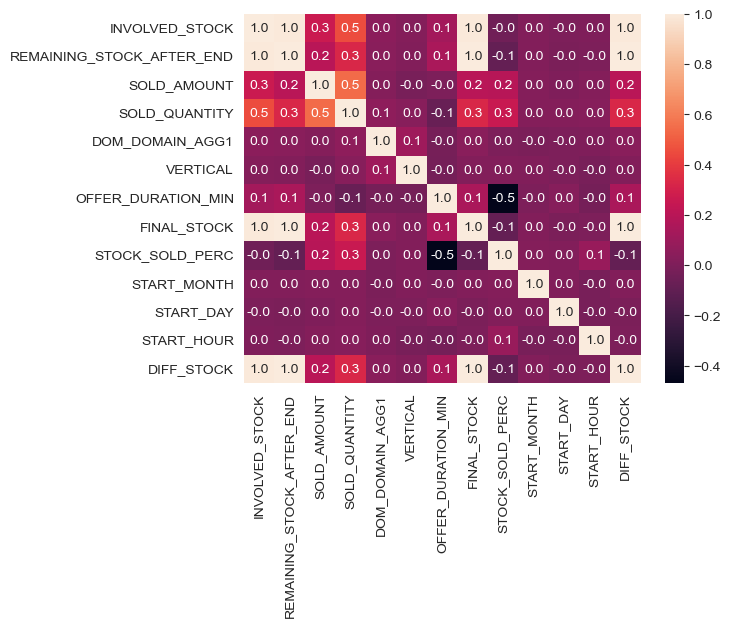

In [52]:
df.drop('START_YEAR', axis=1, inplace=True)
df.drop('STOCK_DIVERGENCE', axis=1, inplace=True)
sns.heatmap(df.corr(), annot = True, fmt = ".1f")
plt.show()

#### Não foram observados correlações significativas nas categorias dos produtos com a venda.